In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from scipy.stats import mannwhitneyu
import scipy.stats

import sys
sys.path.append('../')
from functions import *

In [69]:
save_images = False

In [70]:
def curvature(x_path, y_path,scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r


In [71]:
df_noforce_Mkzero = pd.read_pickle("../fig2_1/noforce_Mkzero_19Jan2022.pkl")


In [72]:
df_noforce_Mkzero = pd.read_pickle("../fig2_1/noforce_Mkzero_19Jan2022.pkl")
df_force_Mkzero = pd.read_pickle("../fig3_1/force_Mkzero.pkl")
df_force_Mknonzero = pd.read_pickle("../fig3_1/force_Mknonzero.pkl")
df_force_FC = pd.read_pickle("effective_point_force.pkl")
df_dynamics = pd.read_pickle("effective_point_force_dynamics.pkl")

df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(['20210811_cell003','20210805_cell002'])]
# df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(['20180622_cell016','20180622_cell020','20180622_cell031','20180628_cell007'])]#,'20190110_cell004_1'])]#,'20180628_cell007'])]
# ,'20190110_cell004_1','20180810_cell006','20180628_cell007'])]
# 20180622_cell016,20180622_cell020,20180622_cell031


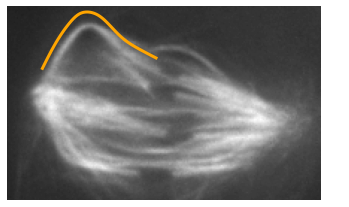

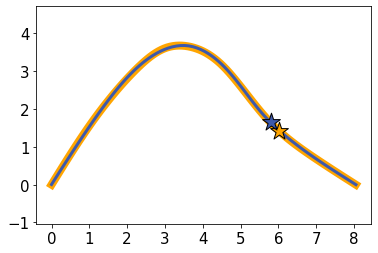

6.024078909044965 5.794981195804503


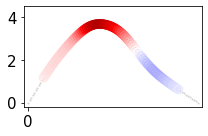

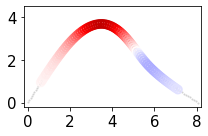

In [105]:
path = "../../dat/WT_manip_20210722"
spindle = "20190927_cell008" # 20210526_cell004, 20210526_cell001, 20180628_cell010, 20180611_cell002

df_filtered_FC = df_force_FC.loc[(df_force_FC['Spindle'] == spindle)]
df_filtered_FC
for index, row in df_filtered_FC.iterrows():
    cell = row["Spindle"]
    df_profile = pd.read_csv("%s/%s/kfiber.csv"%(path,cell))
    x_dat = np.array(df_profile["X"].values)
    y_dat = np.array(df_profile["Y"].values)
    
    image = mpimg.imread("%s/%s/%s_after.tif"%(path,cell,cell))
    plt.imshow(image, cmap ='gray')
    plt.plot([i-2 for i in x_dat], [i-10 for i in y_dat], color = 'orange', lw = 3)

plt.xlim(25,250)
plt.ylim(20,150)
plt.gca().invert_yaxis()
plt.axis("off")
if save_images:
    plt.savefig('fig_outputs/%s_image.pdf'%spindle)
plt.show()


for index, row in df_filtered_FC.iterrows():
    cell = row["Spindle"]

    df_profile = pd.read_csv("%s/%s/kfiber.csv"%(path,cell))
    x_dat = np.array(df_profile["X"].values)
    y_dat = np.array(df_profile["Y"].values)

    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    x_mod = row["x"]
    y_mod = row["y"]
    M_mod = row["M"]
    FC = row["FC"]
    xC = row["xC"]
    xF = row["xF"]
    
    y_dat = np.flip(y_dat)
    x_dat = x_dat[-1] - x_dat[0] - np.flip(x_dat)
    y_mod = np.flip(y_mod)
    x_mod = x_mod[-1] - x_mod[0] - np.flip(x_mod)
    M_mod = np.flip(M_mod)
    xF = np.flip(xF)
    xC = np.flip(xC)
    
    iF_mod = np.where(x_mod > xF)[0][0]
    iF_dat = np.where(x_dat > xF)[0][0]

    s_dat,L_contour_dat = contour_fn(x_dat,y_dat)
    s_mod,L_contour_mod = contour_fn(x_mod,y_mod)

#     M_min_ind = np.where(M_mod == np.min(M_mod[iF_mod:]))[0][0]
    
    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    C_min_ind = np.where(C_dat == np.min(C_dat[iF_dat:]))[0][0]+window
    
    M_mod = curvature(x_mod, y_mod,window)
    M_min_ind = np.where(M_mod == np.min(M_mod[iF_mod:]))[0][0]+window

    plt.plot(x_dat, y_dat, color = 'orange', lw = 8)
    plt.plot(x_mod, y_mod, color = '#3D59AB', lw = 3)
    plt.scatter(x_dat[C_min_ind],y_dat[C_min_ind],marker='*',s=350,color='orange',ec='k',zorder=10)
    plt.scatter(x_mod[M_min_ind],y_mod[M_min_ind],marker='*',s=350,color='#3D59AB',ec='k',zorder=10)

plt.axis("equal")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
if save_images:
    plt.savefig('fig_outputs/%s_FC_fits.pdf'%spindle)
plt.show()
print(x_dat[C_min_ind],x_mod[M_min_ind])

plt.figure(figsize = (3,2))
plt.scatter(x_dat[window:-window], y_dat[window:-window],s = 3, c=C_dat, cmap="seismic", vmin = -1,vmax = 1, lw = 8,zorder=10)
plt.scatter(x_dat, y_dat, color='lightgrey', s=1)
# plt.axis("equal")
plt.ylim(-0.2,4.5)
plt.xlim(-0.2,8.2)
plt.xticks([0],fontsize=15)
plt.yticks([0,2,4], fontsize=15)
plt.tight_layout()
if save_images:
    plt.savefig('fig_outputs/Mkzero_data_curvature.pdf')
plt.show()

plt.figure(figsize = (3,2))
plt.scatter(x_mod[window:-window], y_mod[window:-window],s = 3, c=M_mod, cmap="seismic", vmin = -1,vmax = 1, lw = 8,zorder=10)
plt.scatter(x_mod, y_mod, color='lightgrey', s=1)
# plt.axis("equal")
plt.ylim(-0.2,4.5)
plt.xlim(-0.2,8.2)
plt.xticks([0,2,4,6,8],fontsize=15)
# plt.yticks([0],fontsize=15)
plt.yticks([0,2,4],fontsize=15)
plt.tight_layout()
save_images = True
if save_images:
    plt.savefig('fig_outputs/Fc_model_curvature.pdf')
plt.show()

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


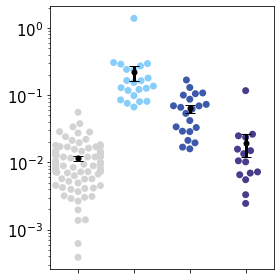

In [74]:
failed_cases = ['20180622_cell016','20180622_cell020','20180622_cell031','20180628_cell007']
df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(failed_cases)]#,'20180628_cell007'])]#,'20180628_cell007'])]

err_noforce_Mkzero = df_noforce_Mkzero["RMSE (exact)"].values
err_force_Mkzero = df_force_Mkzero["RMSE"].values
err_force_Mknonzero = df_force_Mknonzero["RMSE"].values
err_force_FC = df_force_FC["RMSE"].values

var1 = (err_noforce_Mkzero)
var2 = (err_force_Mkzero)
var3 = (err_force_Mknonzero[err_force_Mknonzero<0.18])
var4 = (err_force_FC)
plt.figure(figsize=(4,4))
plt.yscale("log")
sns.swarmplot(data=[var1,var2,var3,var4], palette = ["lightgray", "lightskyblue", "#3D59AB","#483D8B"], size = 7)
plt.errorbar([0,1,2,3],[np.mean(var1),np.mean(var2),np.mean(var3),np.mean(var4)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2)),np.std(var3)/np.sqrt(len(var3)),np.std(var4)/np.sqrt(len(var4))],
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)

# for index,row in df_force_FC.iterrows():
#     spindle = row["Spindle"]
#     rmse = row["RMSE"]
#     if spindle in failed_cases:
#         plt.scatter(3,rmse,zorder=20)

plt.xticks([0,1,2,3], ("","",""))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(0.01,1)
plt.tight_layout()
if save_images:
    plt.savefig('fig_outputs/RMSE.pdf')
plt.show()

# from scipy.stats import mannwhitneyu
# print("mann-whitney U test")
# print("grey to black models", mannwhitneyu(var1, var4, alternative='two-sided')[1])



In [75]:
df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(failed_cases)]#,'20180628_cell007'])]#,'20180628_cell007'])]

minC_val_ls,minC_pos_ls = [],[]
maxC_val_ls,maxC_pos_ls = [],[]
minM_val_ls,minM_pos_ls = [],[]
maxM_val_ls,maxM_pos_ls = [],[]
rmse_ls = []
xC_val_ls = []
FC_val_ls = []
Fext_val_ls = []
for index,row in df_force_FC.iterrows():
    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    x_mod = row["x"]
    y_mod = row["y"]
    M_mod = row["M"]
    xF = row["xF"]
    L = row["L"]
    rmse = row["RMSE"]
    rmse_ls.append(rmse)
    spindle = row["Spindle"]
    xC = row["xC"]
    xC_val_ls.append(xC)
    FC_val_ls.append(row["FC"])
    Fext_val_ls.append(row["Fext"])
    iF_mod = np.where(x_mod > xF)[0][0]
    iF_dat = np.where(x_dat > xF)[0][0]

    s_dat,L_contour_dat = contour_fn(x_dat,y_dat)
    s_mod,L_contour_mod = contour_fn(x_mod,y_mod)

#     M_max_ind = np.where(M_mod == np.max(M_mod))[0][0]
#     M_min_ind = np.where(M_mod == np.min(M_mod[0:iF_mod]))[0][0]

    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    M_mod = curvature(x_mod, y_mod,window)
    
#     if index==3:
#     plt.plot(x_dat,y_dat)
#     plt.show()
#     print(np.median(C_dat))
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0]+window
    C_min_ind = np.where(C_dat == np.min(C_dat[0:iF_dat]))[0][0]+window

    M_max_ind = np.where(M_mod == np.max(M_mod))[0][0]+window
    M_min_ind = np.where(M_mod == np.min(M_mod[0:iF_mod]))[0][0]+window

    minM_val_ls.append(M_mod[M_min_ind-window])
    minM_pos_ls.append(s_mod[M_min_ind])
    maxM_val_ls.append(M_mod[M_max_ind-window])
    maxM_pos_ls.append(s_mod[M_max_ind])
    minC_val_ls.append(C_dat[C_min_ind-window])
    minC_pos_ls.append(s_dat[C_min_ind])
    maxC_val_ls.append(C_dat[C_max_ind-window])
    maxC_pos_ls.append(s_dat[C_max_ind])
    print(index,spindle,C_dat[C_max_ind]-M_mod[M_max_ind],xC,rmse)
#     5,6,7,14
# minC_pos_ls.pop(5)
# minC_pos_ls.pop(4)
# minM_pos_ls.pop(5)
# minM_pos_ls.pop(4)
# xC_val_ls.pop(5)
# xC_val_ls.pop(4)

0 20171215_cell004a -0.033755892800077264 2.8455131435952663 0.02487990338382915
1 20171215_cell004b -0.011416511814850538 2.3940516877338833 0.023643682640897546
2 20171219_cell003c 0.001673940788114947 1.715506483845671 0.006946121663879522
3 20180611_cell002 -0.1408007337469379 1.570346284555 0.007231726762543418
4 20180620_cell013 0.08058887755662358 1.2287499178158796 0.0033113610799854662
8 20180628_cell002 0.052375329510993995 1.6671476027259975 0.006559931934086297
10 20180628_cell010 0.12156158518456006 1.2804076136346503 0.005535427618067461
11 20180810_cell006 -0.0039692163846668516 2.432262350800981 0.014967934612029379
12 20180926_cell007 -0.05110242748369942 1.271711108441026 0.0024554966546292425
13 20190110_cell003 0.08335075082602597 1.3808421198723633 0.1168241833421211
14 20190110_cell004_1 0.10341513185312079 2.7663858097404046 0.013483553585800803
15 20190110_cell004_2 -0.05707590569381876 2.3331845630790276 0.026302659314171584
16 20190110_cell008 0.14349494589216

curvature minima positions:
[ 0.22994726  0.53682143  0.33824075  0.05349697 -0.08912475  0.34168093
 -0.14569825  0.54421717 -0.0557161   0.25560909  0.11051182  0.18913503
  0.30689593  0.32612507  0.4048372 ]
0.8883136447279076 1.4817183239748655e-07


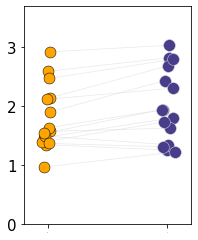

curvature maxima positions:
0.9749336130271383 8.619694057118921e-12


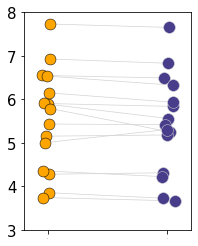

In [76]:
print("curvature minima positions:")
plt.figure(figsize=(3,4))
# plt.title("curvature minima positions")
var1 = (minC_pos_ls)
var2 = (minM_pos_ls)
print(np.array(minM_pos_ls) - np.array(minC_pos_ls))

pearsonr = scipy.stats.pearsonr(var2,var1)
print(pearsonr[0]**2,pearsonr[1])

seed = 4
np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))

plt.scatter(x1,var1,color="orange",edgecolor='k',s=120,zorder=10,lw=0.5)
plt.scatter(x2,var2,color='#483D8B',edgecolor='lightgrey',marker = 'o', s=140,zorder=10,lw=0.5)

for i in range(len(var1)):
    plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightgray',alpha = 0.5)
plt.xlim(-0.2,1.2)
plt.ylim(0,3.7)
plt.xticks([0,1], fontsize=0)
plt.yticks([0,1,2,3])
# plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
if save_images:
    plt.savefig('fig_outputs/curvmin_xC_positions.pdf')
plt.show()


# print("xC vs curvature minima positions:")
# plt.figure(figsize=(3,4))
# # plt.title("Inflection points")
# var1 = (minC_pos_ls)
# var2 = (xC_val_ls)

# seed = 4
# np.random.seed(seed)
# x1 = np.random.normal(0,0.03,len(var1))
# x2 = np.random.normal(1,0.03,len(var2))

# plt.scatter(x1,var1,color="lightgrey",edgecolor='grey',s=100,zorder=10)
# plt.scatter(x2,var2,color='k',edgecolor='lightgrey',s=120,zorder=10)

# for i in range(len(var1)):
#     plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightskyblue')
# plt.xlim(-0.2,1.2)
# plt.ylim(0,5)
# plt.xticks([0, 1], [])
# plt.yticks([0,1,2,3,4,5])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# if save_images:
#     plt.savefig('fig_outputs/xC_vs_curvminima.pdf')
# plt.show()

print("curvature maxima positions:")
plt.figure(figsize=(3,4))
# plt.title("curvature maxima positions")
var1 = (maxC_pos_ls)
var2 = (maxM_pos_ls)
pearsonr = scipy.stats.pearsonr(var2,var1)
print(pearsonr[0]**2,pearsonr[1])

seed = 4
np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))

plt.scatter(x1,var1,color="orange",edgecolor='k',s=120,zorder=10,lw=0.5)
plt.scatter(x2,var2,color='#483D8B',edgecolor='lightgrey',s=140,zorder=10,lw=0.5)

for i in range(len(var1)):
    plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightgrey')
plt.xlim(-0.2,1.2)
plt.ylim(3,8)
plt.xticks([0,1], fontsize=0)
plt.yticks([3,4,5,6,7,8])
# plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
if save_images:
    plt.savefig('fig_outputs/curv_max_positions.pdf')
plt.show()


# print("Inflection points:")
# plt.figure(figsize=(3,4))
# # plt.title("Inflection points")
# var1 = (inflectionC_pos_ls)
# var2 = (inflectionM_pos_ls)

# seed = 4
# np.random.seed(seed)
# x1 = np.random.normal(0,0.03,len(var1))
# x2 = np.random.normal(1,0.03,len(var2))

# plt.scatter(x1,var1,color="lightgrey",edgecolor='grey',s=100,zorder=10)
# plt.scatter(x2,var2,color='k',edgecolor='lightgrey',s=120,zorder=10)

# for i in range(len(var1)):
#     plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightskyblue')
# plt.xlim(-0.2,1.2)
# plt.ylim(0,5.5)
# plt.xticks([0, 1], [])
# plt.yticks([0,1,2,3,4,5])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# if save_images:
#     plt.savefig('fig_outputs/inflection_positions.pdf')
# plt.show()

0.8464214758291042 1.1991037893386615e-06


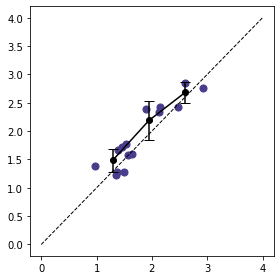

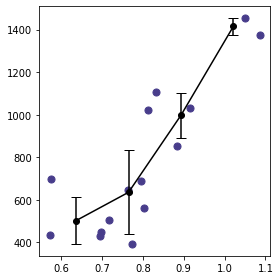

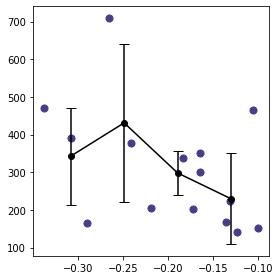

In [77]:
plt.figure(figsize=(4,4))
x=np.array(minC_pos_ls)
y=np.array(xC_val_ls)
pearsonr = scipy.stats.pearsonr(x,y)
print(pearsonr[0]**2,pearsonr[1])

plt.scatter(minC_pos_ls,xC_val_ls,color='#483D8B',s=50)
# plt.scatter(minM_pos_ls,minC_pos_ls,color='k',s=50)
plt.plot([0,4],[0,4],color='k',ls='--',lw=1)
nbins = 3
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)
# plt.xlim(0,3)
# plt.ylim(0,3)
# plt.xticks(np.linspace(0,3,4),fontsize=15)
# plt.yticks(np.linspace(0,3,4),fontsize=15)
plt.tight_layout()
# if save_images:
#     plt.savefig('fig_outputs/shape_mechanics.pdf')
# plt.show()


# df_force_FC = pd.read_pickle("effective_point_force.pkl")
# df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(failed_cases)]#,'20180628_cell007'])]#,'20180628_cell007'])]

plt.figure(figsize=(4,4))

x=np.array(maxC_val_ls)
y=np.array([i*400 for i in Fext_val_ls])
plt.scatter(x,y,color='#483D8B',s=50)
# fit = np.polyfit(maxC_val_ls,[i*400 for i in Fext_val_ls],1)
# plt.plot([0,1.5],[fit[1], fit[0]*1.5 + fit[1]], color='lightgray', ls='--')
nbins = 4#np.array([0.25,0.5,0.75,1,1.25])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)


# plt.xlim(0,3)
# plt.ylim(0,1500)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
x=np.array(minC_val_ls)
y=np.array([i*400 for i in FC_val_ls])
plt.scatter(x,y,color='#483D8B',s=50)
# fit = np.polyfit(minC_val_ls,[i*400 for i in FC_val_ls],1)
# plt.plot([-0.5,0],[fit[0]*-0.5 + fit[1], fit[1]], color='lightgray', ls='--')
nbins = 4#np.array([0.25,0.5,0.75,1,1.25])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)

plt.tight_layout()
plt.show()

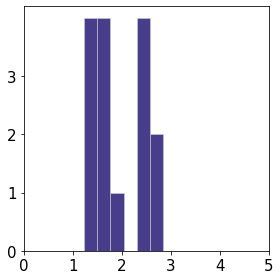

In [78]:
plt.figure(figsize=(4,4))
plt.hist(xC_val_ls,bins=6, color='#483D8B',edgecolor='lightgray',lw=0.5)
plt.xlim(0,5)
plt.xticks(fontsize=15)
plt.yticks([0,1,2,3],fontsize=15)
plt.tight_layout()
if save_images:
    plt.savefig('fig_outputs/xc_hist.pdf')
plt.show()

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 8 Text major ticklabel objects>)

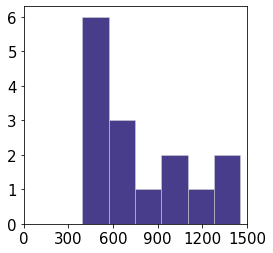

In [79]:
plt.figure(figsize=(4,4))
plt.hist([i*400 for i in Fext_val_ls],bins=6, color='#483D8B',edgecolor='lightgray',lw=0.5)
plt.xlim(200,1500)
plt.xticks([0,300,600,900,1200,1500],fontsize=15)
plt.yticks(fontsize=15)
# plt.yticks([0,1,2,3],fontsize=15)
# plt.tight_layout()
# if save_images:
#     plt.savefig('fig_outputs/FC_hist.pdf')
# plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater_equal


0.6947635534609783 0.00021251986835947373


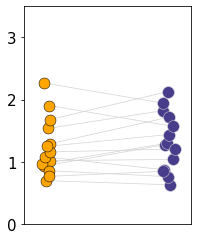

0.8610106834662528 1.733031192689864e-06


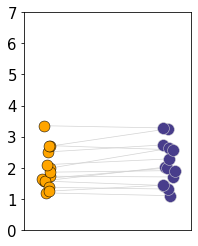

0.9079925475744396 1.4259773348487888e-07


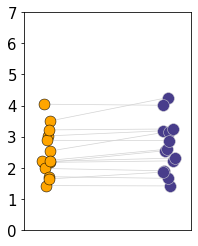

In [80]:
import numpy as np
import numpy.linalg as LA

def angle_bw_vectors(vector1,vector2,units="rad"):
    
    a = np.array([vector1[0], vector1[1]])
    b = np.array([vector2[0], vector2[1]])
    
    inner = np.inner(a, b)
    norms = LA.norm(a) * LA.norm(b)
    
    cos = inner / norms
    rad = np.arccos(np.clip(cos, -1.0, 1.0))
    deg = np.rad2deg(rad)
    
    if units == "rad":
        return rad
    elif units == "deg":
        return deg
    else:
        return "need to define units"
    

cutoff_angle = [1,3,5]

for angle in cutoff_angle:
    dat_ls,mod_ls=[],[]
    for index,row in df_force_FC.iterrows():
        x_dat = row["x_dat"]
        y_dat = row["y_dat"]
        x_mod = row["x"]
        y_mod = row["y"]

        s_dat,L_contour_dat = contour_fn(x_dat,y_dat)
        s_mod,L_contour_mod = contour_fn(x_mod,y_mod)

        angle_dat, angle_mod = [],[]
        n_d=1
        n_m = 1
        for i in range(len(x_dat)):
            vector1 = [x_dat[n_d]-x_dat[0],y_dat[n_d]-y_dat[0]]
            vector2 = [x_dat[i]-x_dat[0],y_dat[i]-y_dat[0]]
            angle_dat.append(angle_bw_vectors(vector1,vector2,"deg"))

        for i in range(len(x_mod)):
            vector1 = [x_mod[n_m]-x_mod[0],y_mod[n_m]-y_mod[0]]
            vector2 = [x_mod[i]-x_mod[0],y_mod[i]-y_mod[0]]
            angle_mod.append(angle_bw_vectors(vector1,vector2,"deg"))

        angle_dat_diff, angle_mod_diff = [],[]
        for i in range(len(angle_dat)-1):
            angle_dat_diff.append(angle_dat[i+1] - angle_dat[i])
        for i in range(len(angle_mod)-1):
            angle_mod_diff.append(angle_mod[i+1] - angle_mod[i])

        ind_dat = np.where(np.array(angle_dat) >= angle)[0][0]
        ind_mod = np.where(np.array(angle_mod) >= angle)[0][0]
        dat_ls.append(s_dat[ind_dat])
        mod_ls.append(s_mod[ind_mod])

    plt.figure(figsize=(3,4))
    # plt.title("curvature maxima positions")
    var1 = (dat_ls)
    var2 = (mod_ls)
    var1.pop(9)
    var2.pop(9)
    pearsonr = scipy.stats.pearsonr(var2, var1)
    print(pearsonr[0]**2,pearsonr[1])

    seed = 4
    np.random.seed(seed)
    x1 = np.random.normal(0,0.03,len(var1))
    x2 = np.random.normal(1,0.03,len(var2))

    plt.scatter(x1,var1,color="orange",edgecolor='k',lw=0.5,s=120,zorder=10)
    plt.scatter(x2,var2,color='#483D8B',edgecolor='lightgrey',lw=0.5,s=140,zorder=10)

    for i in range(len(var1)):
        plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightgrey')
    plt.xlim(-0.2,1.2)
    plt.xticks([])
    plt.yticks([0,1,2,3,4,5,6,7])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if angle == 1:
        plt.ylim(0,3.5)
#     if save_images:
#         plt.savefig('fig_outputs/orientation_angle_%s.pdf'%angle)
    plt.show()


### at what point from the chromosomes does the k-fiber angle hit 5 degrees relative to the plus end? in the data vs model
### could set other cutoff angles for the SI (2,10,etc.). Regardless, our conclusions will be the same

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


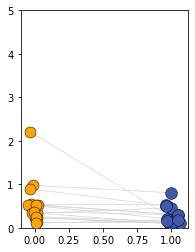

In [81]:
# cutoff_angle = [1,3,5]

# for angle in cutoff_angle:
dat_ls,mod_ls=[],[]
for index,row in df_force_FC.iterrows():
    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    x_mod = row["x"]
    y_mod = row["y"]

#         x_dat = np.flip(x_dat)
#         y_dat = np.flip(y_dat)

    s_dat,L_contour_dat = contour_fn(x_dat,y_dat)
    s_mod,L_contour_mod = contour_fn(x_mod,y_mod)

    angle_dat, angle_mod = [],[]
    n_d=1
    n_m =1
    for i in range(len(x_dat)):
        vector1 = [x_dat[n_d]-x_dat[0],y_dat[n_d]-y_dat[0]]
        vector2 = [x_dat[i]-x_dat[0],y_dat[i]-y_dat[0]]
        angle_dat.append(angle_bw_vectors(vector1,vector2,"deg"))

    for i in range(len(x_mod)):
        vector1 = [x_mod[n_m]-x_mod[0],y_mod[n_m]-y_mod[0]]
        vector2 = [x_mod[i]-x_mod[0],y_mod[i]-y_mod[0]]
        angle_mod.append(angle_bw_vectors(vector1,vector2,"deg"))

    angle_dat_diff, angle_mod_diff = [],[]
    for i in range(len(angle_dat)-1):
        angle_dat_diff.append(angle_dat[i+1] - angle_dat[i])
    for i in range(len(angle_mod)-1):
        angle_mod_diff.append(angle_mod[i+1] - angle_mod[i])

#     plt.plot(s_dat,angle_dat,color="orange")
#     plt.plot(s_mod,angle_mod,color='#3D59AB')
#     plt.show()


    dat_ls.append((angle_dat[3] - angle_dat[1])/(s_dat[3] - s_dat[1]))
    mod_ls.append((angle_mod[3] - angle_mod[1])/(s_mod[3] - s_mod[1]))

plt.figure(figsize=(3,4))
var1 = (dat_ls)
var2 = (mod_ls)

seed = 4
np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))

plt.scatter(x1,var1,color="orange",edgecolor='k',lw=0.5,s=120,zorder=10)
plt.scatter(x2,var2,color='#3D59AB',edgecolor='k',lw=0.5,s=140,zorder=10)

for i in range(len(var1)):
    plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightgrey')
# plt.xlim(-0.2,1.2)
plt.ylim(0,5)
# plt.xticks([])
# plt.yticks([0,1,2,3,4,5,6,7])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# if save_images:
#     plt.savefig('fig_outputs/orientation_angle_%s.pdf'%angle)
plt.show()


### at what point from the chromosomes does the k-fiber angle hit 5 degrees relative to the plus end? in the data vs model
### could set other cutoff angles for the SI (2,10,etc.). Regardless, our conclusions will be the same

In [82]:
var1 = np.array([0.029892101625443136, 0.032842315349488095, 0.034581680871304483, 0.020895276403305043])
var2 = np.array([0.05270659019416363, 0.06022740365969296, 0.0420118117224886, 0.09419413042916164])
mannwhitneyu(var1, var2, alternative='two-sided')[1]

0.03038282197657749

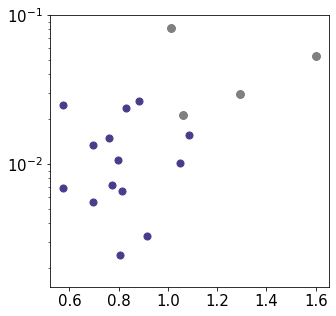

In [83]:
df_force_FC = pd.read_pickle("effective_point_force.pkl")

plt.figure(figsize=(5,5))
plt.yscale('log')
for index,row in df_force_FC.iterrows():
    spindle = row["Spindle"]
    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    spindle = row["Spindle"]
    RMSE = row["RMSE"]
    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0]
#     plt.scatter(1,C_dat[C_max_ind],color='lightgrey', s=100,edgecolor='k',lw=0.5)

#     if spindle in failed_cases:
#         plt.scatter(1,C_dat[C_max_ind],color='k', s=120, zorder=10)
#     plt.xticks([])
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)

    plt.scatter(C_dat[C_max_ind],RMSE,s=50,color='#483D8B')
    if spindle in failed_cases:
        plt.scatter(C_dat[C_max_ind],RMSE,s=60,color='grey')

plt.ylim(0.0015,0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("fig_outputs/failed_cases.pdf")
plt.show()

#max value = /1.4381358357225429

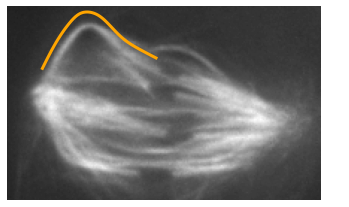

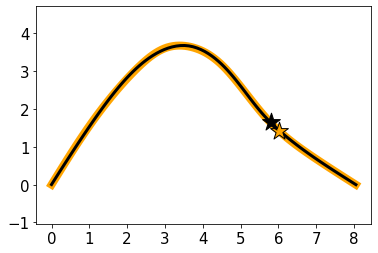

6.024078909044965 5.794981195804503


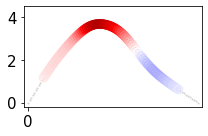

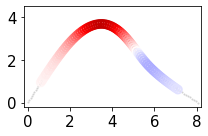

In [84]:
path = "../../dat/WT_manip_20210722"
spindle = "20190927_cell008" # 20210526_cell004, 20210526_cell001, 20180628_cell010, 20180611_cell002

df_filtered_FC = df_force_FC.loc[(df_force_FC['Spindle'] == spindle)]
df_filtered_FC
for index, row in df_filtered_FC.iterrows():
    cell = row["Spindle"]
    df_profile = pd.read_csv("%s/%s/kfiber.csv"%(path,cell))
    x_dat = np.array(df_profile["X"].values)
    y_dat = np.array(df_profile["Y"].values)
    
    image = mpimg.imread("%s/%s/%s_after.tif"%(path,cell,cell))
    plt.imshow(image, cmap ='gray')
    plt.plot([i-2 for i in x_dat], [i-10 for i in y_dat], color = 'orange', lw = 3)

plt.xlim(25,250)
plt.ylim(20,150)
plt.gca().invert_yaxis()
plt.axis("off")
# if save_images:
#     plt.savefig('fig_outputs/%s_image.pdf'%spindle)
plt.show()


for index, row in df_filtered_FC.iterrows():
    cell = row["Spindle"]

    df_profile = pd.read_csv("%s/%s/kfiber.csv"%(path,cell))
    x_dat = np.array(df_profile["X"].values)
    y_dat = np.array(df_profile["Y"].values)

    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    x_mod = row["x"]
    y_mod = row["y"]
    M_mod = row["M"]
    FC = row["FC"]
    xC = row["xC"]
    xF = row["xF"]
    
    y_dat = np.flip(y_dat)
    x_dat = x_dat[-1] - x_dat[0] - np.flip(x_dat)
    y_mod = np.flip(y_mod)
    x_mod = x_mod[-1] - x_mod[0] - np.flip(x_mod)
    M_mod = np.flip(M_mod)
    xF = np.flip(xF)
    xC = np.flip(xC)
    
    iF_mod = np.where(x_mod > xF)[0][0]
    iF_dat = np.where(x_dat > xF)[0][0]

    s_dat,L_contour_dat = contour_fn(x_dat,y_dat)
    s_mod,L_contour_mod = contour_fn(x_mod,y_mod)

#     M_min_ind = np.where(M_mod == np.min(M_mod[iF_mod:]))[0][0]
    
    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    C_min_ind = np.where(C_dat == np.min(C_dat[iF_dat:]))[0][0]+window
    
    M_mod = curvature(x_mod, y_mod,window)
    M_min_ind = np.where(M_mod == np.min(M_mod[iF_mod:]))[0][0]+window

    plt.plot(x_dat, y_dat, color = 'orange', lw = 8)
    plt.plot(x_mod, y_mod, color = 'k', lw = 3)
    plt.scatter(x_dat[C_min_ind],y_dat[C_min_ind],marker='*',s=350,color='orange',ec='k',zorder=10)
    plt.scatter(x_mod[M_min_ind],y_mod[M_min_ind],marker='*',s=350,color='k',ec='k',zorder=10)

plt.axis("equal")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# if save_images:
#     plt.savefig('fig_outputs/%s_FC_fits.pdf'%spindle)
plt.show()
print(x_dat[C_min_ind],x_mod[M_min_ind])

plt.figure(figsize = (3,2))
plt.scatter(x_dat[window:-window], y_dat[window:-window],s = 3, c=C_dat, cmap="seismic", vmin = -1,vmax = 1, lw = 8,zorder=10)
plt.scatter(x_dat, y_dat, color='lightgrey', s=1)
# plt.axis("equal")
plt.ylim(-0.2,4.5)
plt.xlim(-0.2,8.2)
plt.xticks([0],fontsize=15)
plt.yticks([0,2,4], fontsize=15)
plt.tight_layout()
# if save_images:
#     plt.savefig('fig_outputs/Mkzero_data_curvature.pdf')
plt.show()

plt.figure(figsize = (3,2))
plt.scatter(x_mod[window:-window], y_mod[window:-window],s = 3, c=M_mod, cmap="seismic", vmin = -1,vmax = 1, lw = 8,zorder=10)
plt.scatter(x_mod, y_mod, color='lightgrey', s=1)
# plt.axis("equal")
plt.ylim(-0.2,4.5)
plt.xlim(-0.2,8.2)
plt.xticks([0,2,4,6,8],fontsize=15)
# plt.yticks([0],fontsize=15)
plt.yticks([0,2,4],fontsize=15)
plt.tight_layout()
# if save_images:
#     plt.savefig('fig_outputs/Fc_model_curvature.pdf')
plt.show()

In [85]:
df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(failed_cases)]#,'20180628_cell007'])]#,'20180628_cell007'])]
print(np.mean(df_force_FC["FC"].values*1000))
print(np.mean(df_force_FC["Fext"].values*1000))


776.3842456366525
1941.5912169236046


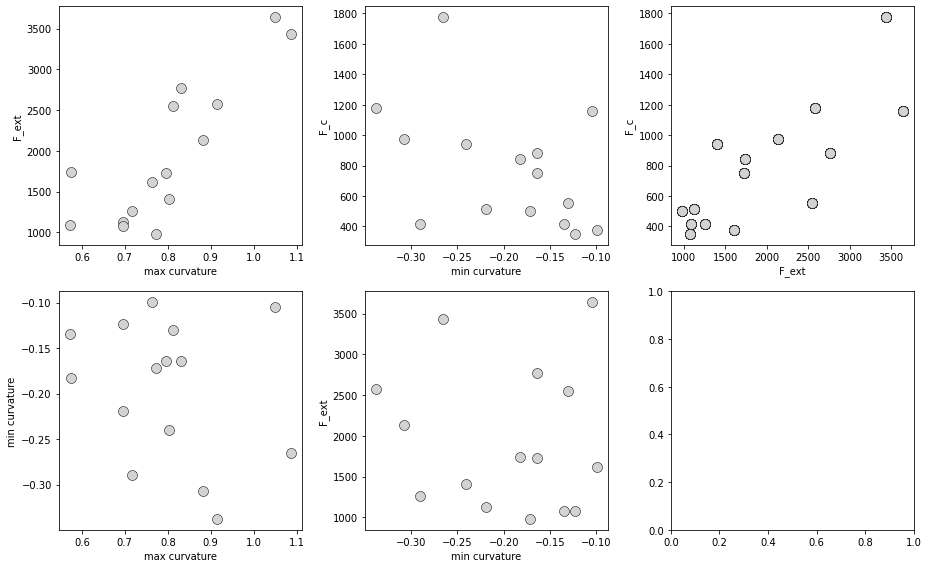

In [86]:
df_force_FC = pd.read_pickle("effective_point_force.pkl")
df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(failed_cases)]#,'20180628_cell007'])]#,'20180628_cell007'])]

# Fext_ls, FC_ls = [],[]
fig, ax = plt.subplots(2, 3, figsize = (13, 8))
for index,row in df_force_FC.iterrows():
    spindle = row["Spindle"]
    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    spindle = row["Spindle"]
#     if index >=10:
#         continue
    Mk = row["Mk"]
    Fx = row["Fx"]
    Fext = row["Fext"]
    Fc = row["FC"]
    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0]
    C_min_ind = np.where(C_dat == np.min(C_dat))[0][0]
    ax[0,0].scatter(C_dat[C_max_ind],Fext*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,1].scatter(C_dat[C_min_ind],Fc*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,2].scatter(df_force_FC["Fext"].values*1000,df_force_FC["FC"].values*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,0].scatter(C_dat[C_max_ind],C_dat[C_min_ind],color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,1].scatter(C_dat[C_min_ind], Fext*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)

    ax[0,0].set_xlabel("max curvature")
    ax[0,0].set_ylabel("F_ext")
    ax[0,1].set_xlabel("min curvature")
    ax[0,1].set_ylabel("F_c")
    ax[0,2].set_xlabel("F_ext")
    ax[0,2].set_ylabel("F_c")
    
    ax[1,0].set_xlabel("max curvature")
    ax[1,0].set_ylabel("min curvature")
    ax[1,1].set_xlabel("min curvature")
    ax[1,1].set_ylabel("F_ext")
    
    
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

#max value = /1.4381358357225429

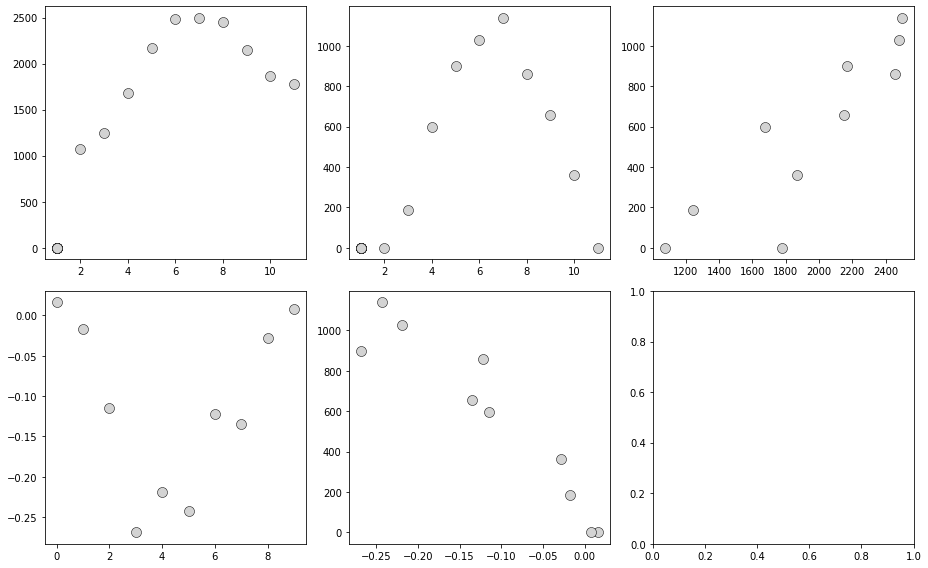

In [87]:
df_dynamics = pd.read_pickle("effective_point_force_dynamics.pkl")

fig, ax = plt.subplots(2, 3, figsize = (13, 8))
for index,row in df_dynamics.iterrows():
#     if index in [0,1,2,3,4,5,6]:
#         continue
    spindle = row["Spindle"]
    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    spindle = row["Spindle"]
#     if index <6:
#         continue
#     print(spindle)
    Mk = row["Mk"]
    Fx = row["Fx"]
    Fext = row["Fext"]
    Fc = row["FC"]
    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0]
    C_min_ind = np.where(C_dat == np.min(C_dat))[0][0]
    ax[0,0].scatter(index+2,Fext*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,1].scatter(index+2,Fc*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,2].scatter(Fext*1000,Fc*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
#     ax[0,2].scatter(df_dynamics["Fext"].values*1000,df_dynamics["FC"].values*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,0].scatter(index,C_dat[C_min_ind],color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,1].scatter(C_dat[C_min_ind], Fc*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,0].scatter(1,0*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,1].scatter(1,0*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)

#     ax[0,0].set_xlabel("max curvature")
#     ax[0,0].set_ylabel("F_ext")
#     ax[0,1].set_xlabel("min curvature")
#     ax[0,1].set_ylabel("F_c")
#     ax[0,2].set_xlabel("F_ext")
#     ax[0,2].set_ylabel("F_c")
    
#     ax[1,0].set_xlabel("max curvature")
#     ax[1,0].set_ylabel("min curvature")
#     ax[1,1].set_xlabel("min curvature")
#     ax[1,1].set_ylabel("F_ext")
    
    
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

#max value = /1.4381358357225429

0.6342984693877548 0.00038046767853463354


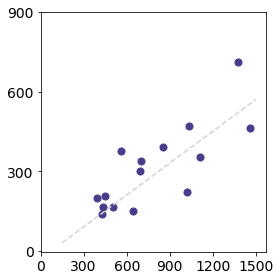

In [91]:
df_force_FC = pd.read_pickle("effective_point_force.pkl")
df_force_FC = df_force_FC[~df_force_FC['Spindle'].isin(failed_cases)]#,'20180628_cell007'])]#,'20180628_cell007'])]
spearmanr = scipy.stats.spearmanr(df_force_FC["FC"].values*400,df_force_FC["Fext"].values*400)
print(spearmanr[0]**2,spearmanr[1])
plt.figure(figsize=(4,4))
plt.scatter(df_force_FC["Fext"].values*400,df_force_FC["FC"].values*400, color="#483D8B", s=50)
fit = np.polyfit(df_force_FC["Fext"].values*400,df_force_FC["FC"].values*400,1)
plt.plot([150,1500],[fit[1], fit[0]*1500 + fit[1]], color='lightgray', ls='--')
# plt.xlabel("External force [EI]",fontsize=14)
# plt.ylabel("Effective crosslinking force [EI]",fontsize=14)
plt.xticks([0,300,600,900,1200,1500], fontsize=14)
plt.yticks([0,300,600,900], fontsize=14)
# plt.axis("equal")
plt.tight_layout()
save_images = True
if save_images:
    plt.savefig("fig_outputs/Fc_vs_Fext.pdf")
plt.show()

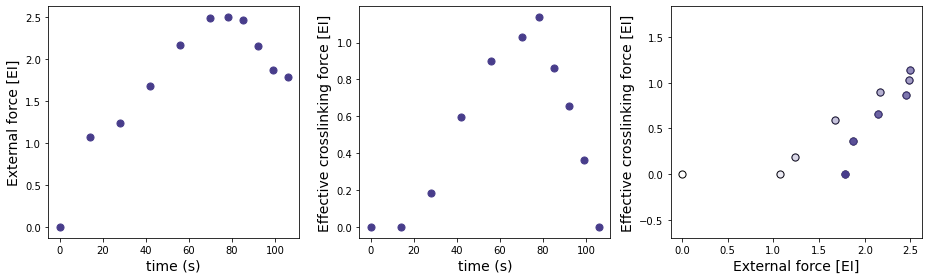

In [92]:
df_dynamics = pd.read_pickle("effective_point_force_dynamics.pkl")
timepoint_ls = [0,14,28,42,56,70,78,85,92,99,106]

fig, ax = plt.subplots(1, 3, figsize = (13, 4))
ax[0].scatter(timepoint_ls,np.insert(df_dynamics["Fext"].values, 0, [0]), color="#483D8B", s = 50)
# ax[0].scatter(timepoint_ls[6],2.5,color='k')
# ax[0].scatter(timepoint_ls[7],2.4,color='k')
# ax[0].scatter(timepoint_ls[8],2.1,color='k')
# ax[0].scatter(timepoint_ls[10],1.78,color='k')
ax[0].set_xlabel("time (s)",fontsize=14)
ax[0].set_ylabel("External force [EI]",fontsize=14)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.show()

ax[1].scatter(timepoint_ls,np.insert(df_dynamics["FC"].values, 0, [0]), color="#483D8B", s = 50)
# ax[1].scatter(timepoint_ls[6],1.13,color='k')
# ax[1].scatter(timepoint_ls[7],0.8,color='k')
# ax[1].scatter(timepoint_ls[8],0.65,color='k')
# ax[1].scatter(timepoint_ls[10],0,color='k')
ax[1].set_xlabel("time (s)",fontsize=14)
ax[1].set_ylabel("Effective crosslinking force [EI]",fontsize=14)
# ax[1].set_xticks(fontsize=13)
# plt.yticks(fontsize=13)

# ax[2].scatter(2.5,1.13,color='k')
# ax[2].scatter(2.4,0.8,color='k')
# ax[2].scatter(2.1,0.65,color='k')
# ax[2].scatter(1.78,0.0,color='k',zorder=10)
# ax[2].plot(np.insert(df_dynamics["Fext"].values, 0, [0]),np.insert(df_dynamics["FC"].values, 0, [0]), color="#483D8B", marker = 'o')
for i in range(len(np.insert(df_dynamics["Fext"].values, 0, [0]))):
    ax[2].scatter(np.insert(df_dynamics["Fext"].values, 0, [0])[i],np.insert(df_dynamics["FC"].values, 0, [0])[i], color="white", s = 51, edgecolor='k')
    ax[2].scatter(np.insert(df_dynamics["Fext"].values, 0, [0])[i],np.insert(df_dynamics["FC"].values, 0, [0])[i], color="#483D8B", s = 50, alpha = 0.1*i)
#     ax[2].text(np.insert(df_dynamics["Fext"].values, 0, [0])[i]+0.02,np.insert(df_dynamics["FC"].values+0.02, 0, [0])[i],'%s'%i)
#     ax[2].text(np.insert(df_dynamics["Fext"].values, 0, [0])[i],np.insert(df_dynamics["FC"].values, 0, [0])[i],'%s'%i)
ax[2].set_xlabel("External force [EI]",fontsize=14)
ax[2].set_ylabel("Effective crosslinking force [EI]",fontsize=14)
ax[2].axis("equal")
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(5,5))
# plt.scatter(df_dynamics["Fext"].values*1000,df_dynamics["FC"].values*1000)
# plt.xlabel("F_ext",fontsize=14)
# plt.ylabel("F_c",fontsize=14)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.show()

20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007
20180926_cell007


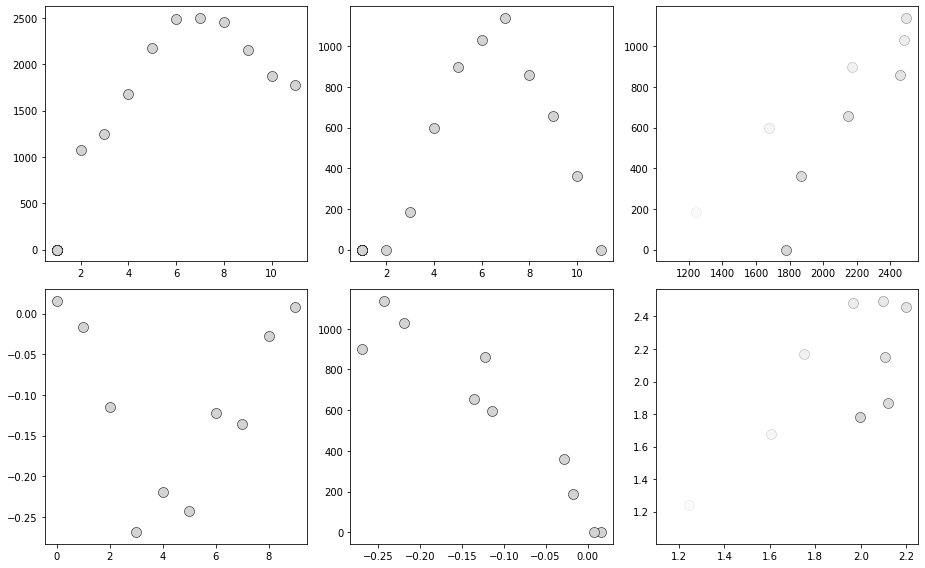

In [93]:
df_dynamics = pd.read_pickle("effective_point_force_dynamics.pkl")

fig, ax = plt.subplots(2, 3, figsize = (13, 8))
for index,row in df_dynamics.iterrows():
#     if index in [0,1,2]:
#         continue
    spindle = row["Spindle"]
    x_dat = row["x_dat"]
    y_dat = row["y_dat"]
    y_max = np.max(y_dat)
    spindle = row["Spindle"]
    if index >=10:
        continue
    print(spindle)
    Mk = row["Mk"]
    Fx = row["Fx"]
    Fext = row["Fext"]
    Fc = row["FC"]
    window = 10
    C_dat = curvature(x_dat, y_dat,window)
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0]
    C_min_ind = np.where(C_dat == np.min(C_dat))[0][0]
    ax[0,0].scatter(index+2,Fext*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,1].scatter(index+2,Fc*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,2].scatter(Fext*1000,Fc*1000,color='lightgrey', alpha = 0.1*index, s=100,edgecolor='k',lw=0.5)
#     ax[0,2].scatter(df_dynamics["Fext"].values*1000,df_dynamics["FC"].values*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,0].scatter(index,C_dat[C_min_ind],color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,1].scatter(C_dat[C_min_ind], Fc*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,0].scatter(1,0*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[0,1].scatter(1,0*1000,color='lightgrey', s=100,edgecolor='k',lw=0.5)
    ax[1,2].scatter(y_max,Fext,color='lightgrey', s=100,alpha = index*0.1 ,edgecolor='k',lw=0.5)

#     ax[0,0].set_xlabel("max curvature")
#     ax[0,0].set_ylabel("F_ext")
#     ax[0,1].set_xlabel("min curvature")
#     ax[0,1].set_ylabel("F_c")
#     ax[0,2].set_xlabel("F_ext")
#     ax[0,2].set_ylabel("F_c")
    
#     ax[1,0].set_xlabel("max curvature")
#     ax[1,0].set_ylabel("min curvature")
#     ax[1,1].set_xlabel("min curvature")
#     ax[1,1].set_ylabel("F_ext")
    
    
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

#max value = /1.4381358357225429

In [94]:
df_force_FC

,FC,Fext,Fx,Fy,L,M,Mk,RMSE,Spindle,gap_max,theta0,thetaF,x,xC,xF,x_dat,y,yF,y_dat
0,0.843882,1.741986,-1.187716,-0.087333,8.480521,"[0.0, -0.0013261197970760264, -0.0039914700715...",-2.244032,0.024880,20171215_cell004a,0.066189,0.097840,1.596607,"[0.0, 0.0906907612857172, 0.18137936849879213,...",2.845513,5.237176,"[0.0, 0.11207226260599157, 0.22401142414179986...","[0.0, 0.008901602140548345, 0.0178251230266206...",1.467250,"[-0.0, 0.009843586121619181, 0.019749353873292..."
1,0.880562,2.769346,-1.403792,-0.413409,7.635723,"[0.0, -0.0013551418482601746, -0.0040815865021...",-1.999985,0.023644,20171215_cell004b,0.053500,0.306914,1.540816,"[0.0, 0.08606410739637321, 0.17212153795762555...",2.394052,4.859551,"[0.0, 0.09799306179926681, 0.19589492115225937...","[0.0, 0.027276107429478693, 0.0545732732829909...",2.216192,"[-0.0, 0.027948467152684515, 0.055991528564145..."
2,0.418492,1.082680,-0.421963,-0.115122,8.616751,"[0.0, -0.0039531152846202615, -0.0118785372494...",1.535110,0.006946,20171219_cell003c,0.013407,0.437488,1.593099,"[0.0, 0.09614011900986694, 0.19224247139062392...",1.715506,4.976897,"[0.0, 0.09351488504728955, 0.18702342516719384...","[0.0, 0.04496618957661361, 0.0900130380252692,...",2.908006,"[-0.0, 0.041224252569484324, 0.082579751860438..."
3,0.503176,0.979389,-0.300752,0.005553,5.458107,"[0.0, -0.004045572080897595, -0.01214291795405...",-2.317903,0.007232,20180611_cell002,0.028846,0.353716,1.194232,"[0.0, 0.06938977013763585, 0.138764193305395, ...",1.570346,4.631316,"[0.0, 0.08082249786669671, 0.161565208450277, ...","[0.0, 0.025621872030928097, 0.0512852688494297...",1.921552,"[-3.730349362740526e-16, 0.029835394057858036,..."
4,1.178315,2.577449,-1.077072,0.091460,6.014917,"[0.0, -0.010517207310773092, -0.03161946719143...",-3.424204,0.003311,20180620_cell013,0.007704,0.165805,1.356336,"[0.0, 0.07741805421008316, 0.15481461263027962...",1.228750,4.546138,"[0.0, 0.08646908588632929, 0.1728259040140916,...","[0.0, 0.012955269483028574, 0.0260383451826635...",2.137705,"[-1.4921397450962103e-15, 0.014998056073445768..."
8,0.556491,2.551017,-1.457900,-0.225340,7.027376,"[0.0, -0.002740876275512708, -0.00825290631279...",-2.380110,0.006560,20180628_cell002,0.018092,0.196286,1.185169,"[0.0, 0.08491214855954889, 0.16981627453224252...",1.667148,6.099812,"[0.0, 0.08673710498498277, 0.17333915584422055...","[0.0, 0.016884441100525824, 0.0338091779401045...",1.860867,"[-0.0, 0.01575847133528015, 0.0317089983476961..."
10,0.513891,1.125740,-0.382852,0.028769,6.245514,"[0.0, -0.0060255142259271486, -0.0180898623802...",4.099375,0.005535,20180628_cell010,0.012218,0.332506,1.288208,"[0.0, 0.07486115591124518, 0.14969760414127453...",1.280408,4.728193,"[0.0, 0.09620175176105228, 0.19217225355457046...","[0.0, 0.025851627323838795, 0.0517746926513138...",2.054731,"[7.460698725481052e-16, 0.0341702719202658, 0...."
11,0.378452,1.611880,-0.604001,-0.317347,8.132628,"[0.0, -0.0012437038139265534, -0.0037417448461...",-8.400822,0.014968,20180810_cell006,0.036347,0.516331,1.416825,"[0.0, 0.09737457150616438, 0.19473374281203956...",2.432262,5.712255,"[0.0, 0.11702563088034523, 0.2338470113574873,...","[0.0, 0.05527960804356691, 0.11058633461541129...",3.488899,"[-7.460698725481052e-16, 0.06326058600785466, ..."
12,0.943560,1.406629,-0.132915,0.157718,5.370531,"[0.0, -0.006912086888969044, -0.02073787719899...",-6.579210,0.002455,20180926_cell007,0.004896,0.459432,1.661936,"[0.0, 0.061859716088586245, 0.1236902043471130...",1.271711,3.072320,"[0.0, 0.07051250470293802, 0.14093228948971603...","[0.0, 0.030604586383251923, 0.0612681788662373...",1.991453,"[-0.0, 0.035455770764688775, 0.071027528671543..."
13,0.413735,1.262131,-0.625652,-0.394505,9.058114,"[0.0, -0.001434952046712401, -0.00431585095592...",4.448331,0.116824,20190110_cell003,0.193974,0.600698,1.783253,"[0.0, 0.08399344689195513, 0.1679700739564472,...",1.380842,3.013907,"[0.0, 0.0880860007565385, 0.17607767310146905,...","[0.0, 0.05754917084884831, 0.11512288267

In [95]:
# np.(0,df_dynamics["Fext"].values*1000,1)
np.insert(df_dynamics["Fext"].values*1000, 0, [0])

array([   0.        , 1073.16417521, 1242.01518881, 1676.26842511,
       2169.96319702, 2481.68632353, 2497.72540342, 2457.15973706,
       2148.76477906, 1870.07147191, 1779.88364843])

In [96]:
df_force_FC_old = pd.read_pickle("effective_point_force_old.pkl")
print(np.mean(df_force_FC["Fext"].values))
print(np.mean(df_force_Mkzero["Fext"].values))

1.9415912169236054
1.9976098057384242


In [97]:
len(np.insert(df_dynamics["Fext"].values, 0, [0]))

11

In [98]:
df_force_FC["Fext"].mean()*400, df_force_FC["Fext"].min()*400, df_force_FC["Fext"].max()*400

(776.6364867694422, 391.75561809020934, 1455.7246597612648)

In [99]:
df_force_FC["FC"].mean()*400

310.55369825466096

1.602027161909653


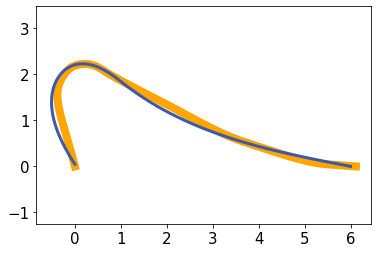

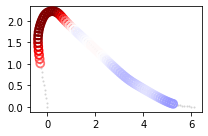

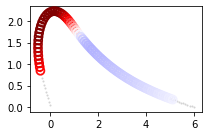

1.0128812351240446


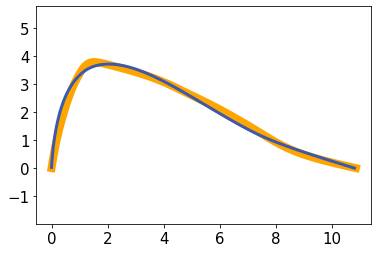

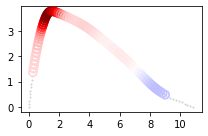

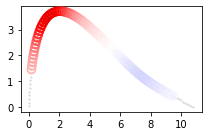

In [109]:
df_force_FC = pd.read_pickle("effective_point_force.pkl")
path = "../../dat/WT_manip_20210722"
spindles = ["20180622_cell020","20180628_cell007"] # 20210526_cell004, 20210526_cell001, 20180628_cell010, 20180611_cell002


for spindle in spindles:
    df_filtered_FC = df_force_FC.loc[(df_force_FC['Spindle'] == spindle)]
    df_filtered_FC

    for index, row in df_filtered_FC.iterrows():
        cell = row["Spindle"]

        df_profile = pd.read_csv("%s/%s/kfiber.csv"%(path,cell))
        x_dat = np.array(df_profile["X"].values)
        y_dat = np.array(df_profile["Y"].values)

        x_dat = row["x_dat"]
        y_dat = row["y_dat"]
        x_mod = row["x"]
        y_mod = row["y"]
        M_mod = row["M"]
        FC = row["FC"]
        xC = row["xC"]
        xF = row["xF"]

        y_dat = np.flip(y_dat)
        x_dat = x_dat[-1] - x_dat[0] - np.flip(x_dat)
        y_mod = np.flip(y_mod)
        x_mod = x_mod[-1] - x_mod[0] - np.flip(x_mod)
        M_mod = np.flip(M_mod)
        xF = np.flip(xF)
        xC = np.flip(xC)

        window = 10
        C_dat = curvature(x_dat, y_dat,window)
        print(max(C_dat))
        C_min_ind = np.where(C_dat == np.min(C_dat[iF_dat:]))[0][0]+window

        M_mod = curvature(x_mod, y_mod,window)
        M_min_ind = np.where(M_mod == np.min(M_mod[iF_mod:]))[0][0]+window

        s_dat,L_contour_dat = contour_fn(x_dat,y_dat)
        s_mod,L_contour_mod = contour_fn(x_mod,y_mod)

        plt.plot(x_dat, y_dat, color = 'orange', lw = 8)
        plt.plot(x_mod, y_mod, color = '#3D59AB', lw = 3)

    plt.axis("equal")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
#     if save_images:
    plt.savefig('fig_outputs/failed_%s.pdf'%spindle)
    plt.show()
    
    
    plt.figure(figsize = (3,2))
    plt.scatter(x_dat[window:-window], y_dat[window:-window],s = 3, c=C_dat, cmap="seismic", vmin = -1,vmax = 1, lw = 8,zorder=10)
    plt.scatter(x_dat, y_dat, color='lightgrey', s=1)
    # plt.axis("equal")
#     plt.ylim(-0.2,4.5)
#     plt.xlim(-0.2,8.2)
#     plt.xticks([0],fontsize=15)
#     plt.yticks([0,2,4], fontsize=15)
    plt.tight_layout()
    # if save_images:
    #     plt.savefig('fig_outputs/Mkzero_data_curvature.pdf')
    plt.show()
    
    plt.figure(figsize = (3,2))
    plt.scatter(x_mod[window:-window], y_mod[window:-window],s = 3, c=M_mod, cmap="seismic", vmin = -1,vmax = 1, lw = 8,zorder=10)
    plt.scatter(x_mod, y_mod, color='lightgrey', s=1)
    # plt.axis("equal")
#     plt.ylim(-0.2,4.5)
#     plt.xlim(-0.2,8.2)
#     plt.xticks([0,2,4,6,8],fontsize=15)
#     # plt.yticks([0],fontsize=15)
#     plt.yticks([0,2,4],fontsize=15)
    plt.tight_layout()
    # if save_images:
    #     plt.savefig('fig_outputs/Fc_model_curvature.pdf')
    plt.show()
    